In [43]:
%matplotlib inline

import json
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import util
from skimage import io
from skimage import exposure
from skimage import morphology
from skimage import measure
from skimage import filters
from skimage import registration
from skimage import transform
from skimage import color

PATH='../spotGEO/'

def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def get_targets(seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0,1)


def draw_circle(ax, x, y, r, color):
    circle = plt.Circle((x, y), r, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, x, y):
    draw_circle(ax, x, y, r=10, color='r')
    
    
def draw_prediction(ax, x, y):
    draw_circle(ax, x, y, r=10, color='g')
    
    
def extract_region(arr, x, y, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)]


def register(src, dst):
    shifts, _, _ = registration.phase_cross_correlation(dst, src, upsample_factor=100)
    return transform.SimilarityTransform(translation=-np.flip(shifts))

Dataset contains 1280 elements
(5, 480, 640)
(3, 5, 2)


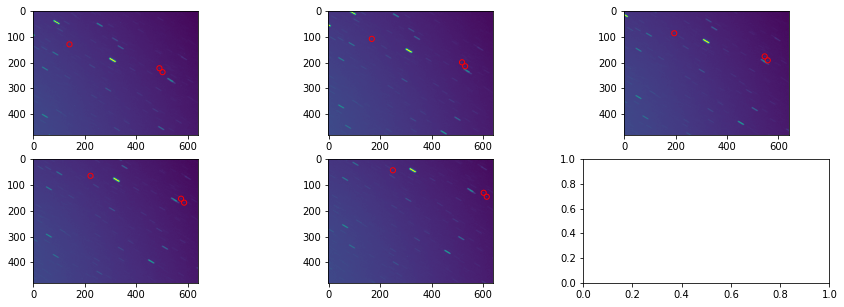

In [12]:
dataset = read_annotation_file(os.path.join(PATH, 'train_anno.json'))

print('Dataset contains', len(dataset), 'elements')

frames = get_sequence(1)
targets = get_targets(1)

print(frames.shape)
print(targets.shape)

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for frameid in range(0,5):
    axs[frameid].imshow(frames[frameid])    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])    
plt.show()


[[502.40625    237.11458333]
 [530.40625    214.11458333]
 [558.40625    191.11458333]
 [586.40625    168.11458333]
 [614.40625    145.11458333]]


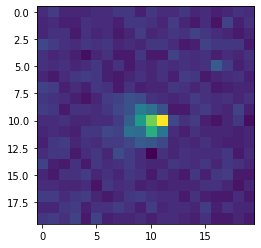

In [50]:
target = targets[0]

print(target)

x0, y0 = target[0, 0], target[0, 1]
x0 = int(x0)
y0 = int(y0)
# Iregion = extract_region(frames[0], int(x0), int(y0), 10)
Iregion = frames[0][y0-10:y0+10, x0-10:x0+10]

plt.imshow(Iregion)


<SimilarityTransform(matrix=
    [[  1.  ,  -0.  ,   4.22],
     [  0.  ,   1.  , -36.86],
     [  0.  ,   0.  ,   1.  ]])> <SimilarityTransform(matrix=
    [[  1.  ,  -0.  ,   4.17],
     [  0.  ,   1.  , -36.95],
     [  0.  ,   0.  ,   1.  ]])> <SimilarityTransform(matrix=
    [[  1.  ,  -0.  ,   4.32],
     [  0.  ,   1.  , -36.9 ],
     [  0.  ,   0.  ,   1.  ]])> <SimilarityTransform(matrix=
    [[  1.  ,  -0.  ,   4.23],
     [  0.  ,   1.  , -36.97],
     [  0.  ,   0.  ,   1.  ]])>
[[  1.      0.      4.225]
 [  0.      1.    -36.925]
 [  0.      0.      1.   ]]


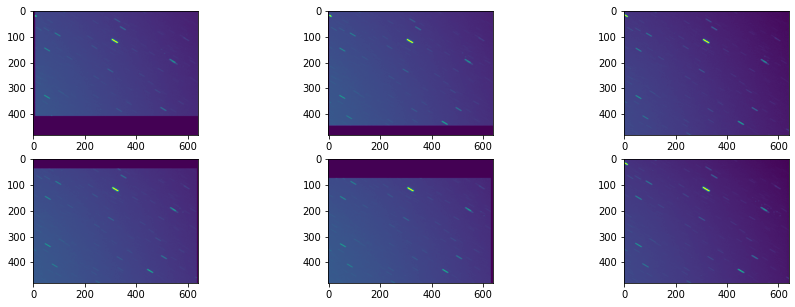

In [18]:
T1 = register(frames[1], frames[0])
T2 = register(frames[2], frames[1])
T3 = register(frames[3], frames[2])
T4 = register(frames[4], frames[3])

print(T1, T2, T3, T4)

# Sometimes the transformation matrix may return outlier transformations
# here we assume the same transformation matrix repeated for all the frames
Q = np.array([T.params.ravel() for T in [T1, T2, T3, T4]])

T = np.median(Q, axis=0).reshape(3,3)

print(T)

T_to2 = [
    T @ T,
    T,
    np.eye(3),
    np.linalg.inv(T),
    np.linalg.inv(T @ T)
]

frame0_2 = transform.warp(frames[0], np.linalg.inv(T @ T))
frame1_2 = transform.warp(frames[1], np.linalg.inv(T))
frame2_2 = frames[2]
frame3_2 = transform.warp(frames[3], T)
frame4_2 = transform.warp(frames[4], T @ T)

sequence = np.array([frame0_2, frame1_2, frame2_2, frame3_2, frame4_2])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, frame in enumerate(sequence):
    axs[i].imshow(frame)
    
axs[i+1].imshow(np.max(sequence, axis=0))

plt.show()

[304.225 143.075]


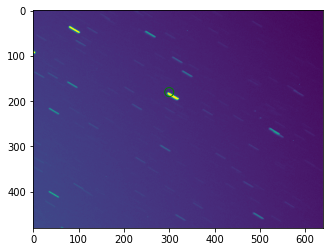

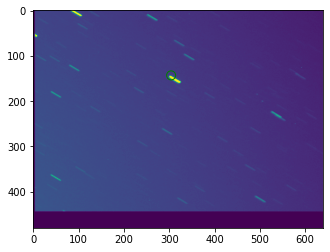

In [35]:
z = transform.matrix_transform([[300, 180]], T)[0]

print(z)

plt.imshow(frames[0])
draw_circle(plt.gcf().gca(), 300, 180, r=10, color='g')
plt.show()

frame0_1 = transform.warp(frames[0], np.linalg.inv(T))

plt.imshow(frame0_1)
draw_circle(plt.gcf().gca(), z[0], z[1], r=10, color='g')
plt.show()